# Mount **Google Drive** and Initialize **Directories**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
home_dir = '/content/drive/MyDrive/nlp2023-hw2'
dir_data= home_dir+'/data/coarse-grained'

train_json= dir_data+'/train_coarse_grained.json'
val_json= dir_data+'/val_coarse_grained.json'
test_json= dir_data+'/test_coarse_grained.json'

dir_bert_tokenizer = home_dir+'/model/bert_tokenizer'
dir_bert_model = home_dir+'/model/bert_model'

dir_roberta_tokenizer = home_dir+'/model/roberta_tokenizer'
dir_roberta_model = home_dir+'/model/roberta_model'

# **Hardware check**

In [3]:
try:
    import torch
    print("PyTorch version:", torch.__version__)
except ImportError:
    !pip3 install torch


# Check GPU availability
if torch.cuda.is_available():
    device = 'cuda'
    device_name = torch.cuda.get_device_name(0)
    print("Using GPU:", device)
else:
    device = 'cpu'
    print("Using CPU")

PyTorch version: 2.0.1+cu118
Using GPU: cuda


# **Software check**

Pytorch Lightning

In [4]:
try:
    import pytorch_lightning as pl
    print("PyTorch Lightning version:", pl.__version__)
except ImportError:
    !pip install jedi>0.16
    !pip install setuptools>65.5.1
    !pip3 install pytorch_lightning==1.5.10
    import pytorch_lightning as pl
    print("PyTorch Lightning version:", pl.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.4/952.4 kB 59.9 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.15.1 requires setuptools>=60.0.0, but you have setuptools 59.5.0 which is incompatible.
cvxpy 1.3.2 requires setuptools>65.5.1, but you have setuptools 59.5.0 which is incompatible.


PyTorch Lightning version: 1.5.10


Transformers

In [5]:
try:
    import transformers
    print("Transformers version:", transformers.__version__)
except ImportError:
    !pip install transformers
    import transformers
    print("Transformers version:", transformers.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.0 MB/s eta 0:00:00
Transformers version: 4.33.0


# **Imports**

Utils

In [38]:
from typing import Callable, Optional, List, Union, Dict, Tuple
from collections import Counter
from collections import defaultdict
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import json
import pickle
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import yaml
from matplotlib.patches import FancyBboxPatch

Neural Networks:

In [43]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from transformers import BertModel, BertTokenizerFast, RobertaTokenizerFast, RobertaModel

PyTorch Lightning

In [8]:
from pytorch_lightning.loggers import CSVLogger

# Execute this section **only the first time!!!!**

Create **vocabulary** for:

*   pos_tags

Create **mappings**:

*   from CANDIDATES to INTEGERS (label_to_id)
*   from INTEGERS to CANDIDATES (id_to_label)

All these vocabs and mappings were obtained iterating **over train data**.

Note: By using the most_common() function, we can get a list of the most frequent words in the train sentences, sorted by how frequently they appear. Understanding which words predominate in the sample is helpful, and having them at the beginning of the vocabularies can be crucial for the performance of the model.

In [ ]:
# First, define the method for the creation of vocabularies and mappings

def init_vocab(train_data):
  # Create a Counter for pos_tags and candidates
  pos_tag_counter = Counter()
  candidate_counter = Counter()
  # Iterate through training data to count and add pos_tags and candidates to their respective counters
  for instance in train_data:
      pos_tags = instance["pos_tags"]
      candidates = instance["candidates"]
      pos_tag_counter.update(pos_tags)
      candidate_counter.update(candidates)

  # Create vocabulary dictionaries for pos_tags and candidates (since padding will be considered as 0, they all start from 1 and the "unknown" tokens will be considered as -100
  pos_tag_vocab = {"UNK" : -100, "[PAD]" : 0, **{pos_tag: idx for idx, (pos_tag, _) in enumerate(pos_tag_counter.most_common(), start=1)}}
  # Define a vocab dict to map the labels to int (and vice versa)
  label_to_id = {"UNK" : 0, **{candidate: idx for idx, (candidate, _) in enumerate(candidate_counter.most_common(), start=1)}}
  id_to_label = {i: n for n, i in label_to_id.items()}

  #Save them in binary files:

  with open(home_dir+"/model/pos_tag_vocab.pickle", "wb") as file:
      pickle.dump(pos_tag_vocab, file)

  with open(home_dir+"/model/label_to_id.pickle", "wb") as file:
      pickle.dump(label_to_id, file)

  with open(home_dir+"/model/id_to_label.pickle", "wb") as file:
      pickle.dump(id_to_label, file)

# Then, from the json file containing all train sentences, define train_data as List[Dict],
# where each dictionary corresponds to a target instance

# Load the train JSON file
with open(train_json, 'r') as json_file:
    train_data_dict = json.load(json_file)
    with open(home_dir+"/model/train_data_dict.pickle", "wb") as file:
      pickle.dump(train_data_dict, file)

# Convert the train data dictionary to a list of dictionaries
train_data = []

for key, value in train_data_dict.items():
    target_list = list(value['candidates'].keys()) #take the indices of the target words in the sentence
    for target in target_list: #for each target word
      item =  { #create a new instance
        "sentence_id": key, # saved for inverse mapping (from separated predictions of each target in a sentence,
                            # to a list of predictions for all the target in the "sentence_id" sentence)
        "target_pos": int(target),
        "lemmas": value["lemmas"],
        "words": value["words"],
        "pos_tags": value["pos_tags"],
        "sense": value["senses"][target][0],
        "candidates": value["candidates"][target]
      }
      train_data.append(item)

with open(home_dir+"/model/train_data.pickle", "wb") as file:
      pickle.dump(train_data, file)

# Finally, call "init_vocab" with the train_data list of dictionaries
init_vocab(train_data)

Save **tokenizer** and **transformer** models

In [ ]:
# BERT tokenizer and model
bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')
bert_model = BertModel.from_pretrained("bert-base-cased")
bert_model.save_pretrained(dir_bert_model)
bert_tokenizer.save_pretrained(dir_bert_tokenizer)

# Roberta tokenizer and model
roberta_tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')
roberta_model = RobertaModel.from_pretrained("roberta-base")
roberta_model.save_pretrained(dir_roberta_model)
roberta_tokenizer.save_pretrained(dir_roberta_tokenizer)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


('/content/drive/MyDrive/nlp2023-hw2/model/roberta_tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/nlp2023-hw2/model/roberta_tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/nlp2023-hw2/model/roberta_tokenizer/vocab.json',
 '/content/drive/MyDrive/nlp2023-hw2/model/roberta_tokenizer/merges.txt',
 '/content/drive/MyDrive/nlp2023-hw2/model/roberta_tokenizer/added_tokens.json',
 '/content/drive/MyDrive/nlp2023-hw2/model/roberta_tokenizer/tokenizer.json')

# **Data Plots**

**Sentence Length Distribution**: Analyze the distribution of sentence lengths to understand the range of sentence lengths in the data.


Running this code will generate a histogram showing the distribution of sentence lengths in the training data. This information can be useful for the Word Sense Disambiguation model, as it may affect how we handle input data during preprocessing and model architecture design (especially in tokenization and in transformer model).

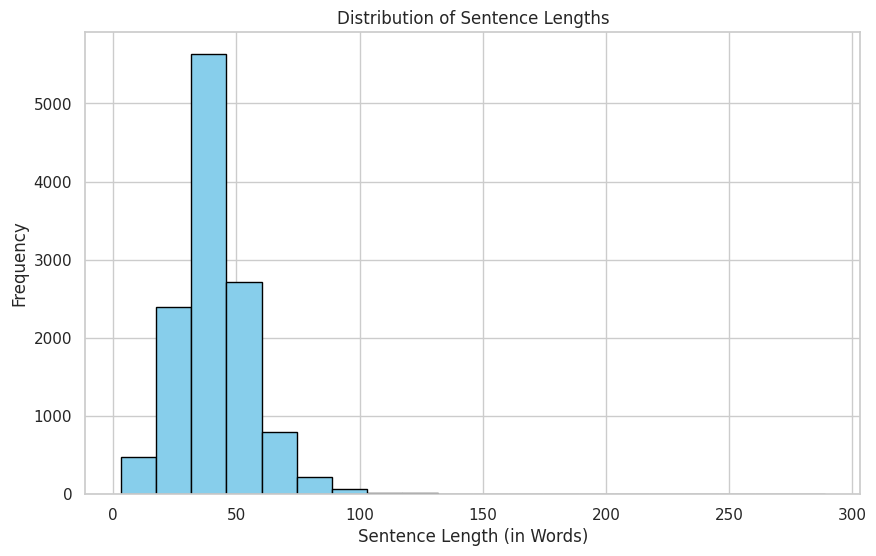

In [ ]:

with open(home_dir + "/model/train_data_dict.pickle", "rb") as file:
    train_data_dict = pickle.load(file)

# Calculate the lengths of sentences in terms of words
sentence_lengths = [len(instance["words"]) for sent_id, instance in train_data_dict.items()]

# Create a histogram of sentence lengths
plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Sentence Length (in Words)')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths')
plt.grid(True)
plt.show()


Create a plot to visualize the **co-occurrence** of the same **words** with their corresponding **POS tags** and true senses to analyze whether there's a pattern where the same word and POS tag consistently correspond to the **same sense.**

Percentage of multi_sense_pairs w.r.t. total word-pos pairs:
53.34520478249809
Percentage of multi_sense_pairs with same sense w.r.t. multi_sense_pairs:
84.31092036242251


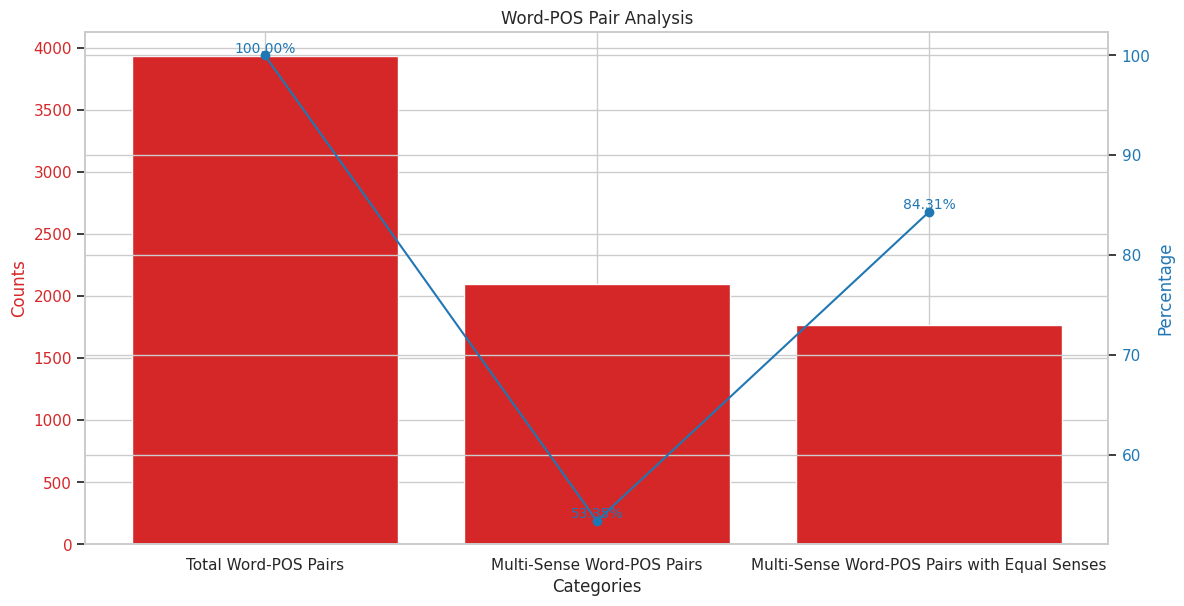

In [ ]:

with open(home_dir + "/model/train_data.pickle", "rb") as file:
    train_data = pickle.load(file)

# Create a dictionary to store co-occurrence information
co_occurrence = defaultdict(list)

# Iterate through the training data and collect co-occurrence information
for instance in train_data:
    words = instance["words"]
    pos_tags = instance["pos_tags"]
    target_pos = instance["target_pos"]
    sense = instance["sense"]

    # Combine word and POS tag into a tuple
    word_pos_pair = (words[target_pos], pos_tags[target_pos])

    co_occurrence[word_pos_pair].append(sense)

# Calculate the total number of word-pos pairs
total_pairs = len(co_occurrence)

# Calculate the number of word-pos pairs with more than one sense in their sense list
multi_sense_pairs = sum(1 for pair in co_occurrence.values() if len(pair) > 1)

# Calculate the number of word-pos pairs with more than one sense in their sense list and all senses are equal
same_sense_count = sum(1 for pair in co_occurrence.values() if len(set(pair)) == 1 and len(pair) > 1)

print("Percentage of multi_sense_pairs w.r.t. total word-pos pairs:")
percentage_total = (multi_sense_pairs / total_pairs) * 100
print(percentage_total)

print("Percentage of multi_sense_pairs with same sense w.r.t. multi_sense_pairs:")
percentage_multi_sense = (same_sense_count / multi_sense_pairs) * 100
print(percentage_multi_sense)

# Create the bar chart
categories = ['Total Word-POS Pairs', 'Multi-Sense Word-POS Pairs', 'Multi-Sense Word-POS Pairs with Equal Senses']
counts = [total_pairs, multi_sense_pairs, same_sense_count]
percentages = [100, percentage_total, percentage_multi_sense]

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Categories')
ax1.set_ylabel('Counts', color=color)
ax1.bar(categories, counts, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Percentage', color=color)
ax2.plot(categories, percentages, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

# Add text annotations for the percentages
for i, percentage in enumerate(percentages):
    ax2.text(categories[i], percentage, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=10, color=color)

fig.tight_layout()
plt.title('Word-POS Pair Analysis')
plt.show()


# **Dataset**

Instance-format of the dataset:

```
sample = {
    "d000.s002": {
        "instance_ids": {
            "1": "d000.s002.t000",
            "5": "d000.s002.t001"
        },
        "lemmas": ["the", "race", "will", "take", "place", "today"],
        "words": ["The", "races", "will", "take", "place", "today"],
        "pos_tags": ["DT", "NOUN", "VB", "VB", "NOUN", "ADP"],
        "senses": {
            "1": "race.n.h.01",
            "5": "today.r.h.01"
        },
        "candidates": {
            "1": ["race.n.h.01", "race.n.h.02"],
            "5": ["today.r.h.01"]
        }
    }
}

```



Define the Dataset class:


*   "__init__" method takes and loads the input JSON file; then, starting with sentences from JSON file, each target word will correspond to a new data item
*   "__len__" returns dataset length (total number of target words).
*   "__get_item__" returns item in the dataset with idx-position.






In [23]:
class WSDDataset(Dataset):
    def __init__(self, data_json):
        # Load the JSON file
        with open(data_json, 'r') as json_file:
            data_dict = json.load(json_file)

        # Convert the dictionary to list of dictionaries
        data = []

        for key, value in data_dict.items():
            target_list = list(value['candidates'].keys()) #take the indices of the target words in the sentence
            for target in target_list: #for each target word
              item =  { #create a new instance
                "sentence_id": key, # saved for inverse mapping (from separated predictions of each target in a sentence,
                                    # to a list of predictions for all the target in the "sentence_id" sentence)
                "target_pos": int(target),
                "lemmas": value["lemmas"],
                "words": value["words"],
                "pos_tags": value["pos_tags"],
                "sense": value["senses"][target][0],
                "candidates": value["candidates"][target]
              }
              data.append(item)

        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return item

# **Dataloader**


Defines a custom collate function for data loaders.

    Args:
        batch (list): List of samples from the dataset.
        use_lemmas (bool): Indicates whether to use lemmas for target words and sentences.

    Returns:
        dict: A batch dictionary with the following keys:
            - "sentence_ids": List of sentence IDs for tracking.
            - "target_words": List of target words (either words or lemmas based on use_lemmas).
            - "sentences": List of sentences (either words or lemmas based on use_lemmas).
            - "pos_tags": List of integer representations of target words' POS tags
              (or -100 if not found in the POS tag vocabulary).
            - "labels": List of integer representations of target word senses
              (or -100 if not found in the mapping table).
            - "candidate_masks": List of candidate masks with elements being 1 for possible candidates
              and 0 otherwise.









In [42]:
def collate_fn(batch, use_lemmas):
    sentence_ids = []
    targets_pos = []
    target_words = []
    sentences = []
    pos_tags = []
    senses = []
    candidates = []


    for item in batch:
        sentence_ids.append(item["sentence_id"])

        target_pos = item["target_pos"]
        targets_pos.append(target_pos)

        target_word = item["lemmas"][target_pos] if use_lemmas else item["words"][target_pos]

        target_words.append(target_word)

        sentence = " ".join(item["lemmas"]) if use_lemmas else " ".join(item["words"])
        sentences.append(sentence)

        pos_tag = item["pos_tags"][target_pos]

        pos_tags.append(pos_tag)

        senses.append(item["sense"])
        candidates.append(item["candidates"])


    encoded_pos_tags = [pos_tag_vocab[pos_tag] if pos_tag in pos_tag_vocab else pos_tag_vocab["UNK"] for pos_tag in pos_tags]

    encoded_senses = [label_to_id[sense] if sense in label_to_id else label_to_id["UNK"] for sense in senses]
    candidate_masks = torch.zeros(len(batch), len(label_to_id))

    for i, cand_list in enumerate(candidates):
        for cand in cand_list:
            cand_id = label_to_id[cand] if cand in label_to_id else label_to_id["UNK"]
            candidate_masks[i, cand_id] = 1

    return {
        "sentence_ids": sentence_ids,
        "target_words": target_words,
        "sentences": sentences,
        "pos_tags": torch.tensor(encoded_pos_tags),
        "labels": torch.tensor(encoded_senses),
        "candidate_masks": candidate_masks
    }


Define the DataModule class for the WSDModel, crucial for the creation of datasets and dataloaders (took some code from "Notebook #7 - Pytorch Lightning")

In [25]:
class WSDDataModule(pl.LightningDataModule):

    def __init__(
        self,
        data_train_path: str,
        data_dev_path: str,
        data_test_path: str,
        batch_size: int,
        use_lemmas
    ) -> None:
        super().__init__()
        self.data_train_path = data_train_path
        self.data_dev_path = data_dev_path
        self.data_test_path = data_test_path
        self.batch_size = batch_size
        self.use_lemmas = use_lemmas
        self.collate_fn = lambda batch: collate_fn(batch, self.use_lemmas)

        self.train_dataset = None
        self.validation_dataset = None
        self.test_dataset = None

    def setup(self, stage: Optional[str] = None) -> None:
        if stage == 'fit':
            self.train_dataset = WSDDataset(self.data_train_path)
            self.validation_dataset = WSDDataset(self.data_dev_path)
        elif stage == 'test':
            self.test_dataset = WSDDataset(self.data_test_path)

    def train_dataloader(self, *args, **kwargs) -> DataLoader:
        return DataLoader(self.train_dataset, batch_size=self.batch_size, collate_fn=self.collate_fn, shuffle=True)

    def val_dataloader(self, *args, **kwargs) -> Union[DataLoader, List[DataLoader]]:
        return DataLoader(self.validation_dataset, batch_size=self.batch_size, collate_fn=self.collate_fn, shuffle=False)

    def test_dataloader(self, *args, **kwargs) -> Union[DataLoader, List[DataLoader]]:
        return DataLoader(self.test_dataset, batch_size=self.batch_size, collate_fn=self.collate_fn, shuffle=False)

# **Model** and **Trainer**

Define the Model class, which contains both model definition (took some code from "Notebook #5 - Transformers") and Trainer steps (took some code from "Notebook #7 - Pytorch Lightning").

In [82]:
class WSDModel(pl.LightningModule):
    def __init__(self,
                 model,
                 tokenizer) -> None:

        super().__init__()

        # save useful hyperparameters for the model as its attributes
        self.num_candidates = len(label_to_id)
        self.dropout_rate = hparams["dropout_rate"]
        self.learning_rate = hparams["learning_rate"]
        self.use_pos = hparams["use_pos"]
        self.num_pos_tags = len(pos_tag_vocab)
        self.id_to_label = id_to_label
        # save all hyperparameters for reproducibility of the experiment
        self.save_hyperparameters(hparams)

        # define key structures of the entire model
        self.transformer_model = model # the pretrained language model, based on transformer architecture.
        self.tokenizer = tokenizer # the pretrained tokenizer corresponding to the above transformer model
        self.pos_embedding = nn.Embedding(self.num_pos_tags, self.transformer_model.config.hidden_size)  # Define the POS tag embedding layer
        self.dropout = nn.Dropout(self.dropout_rate)
        self.linear = nn.Linear(self.transformer_model.config.hidden_size, self.num_candidates) # linear layer that returns the logits

    def get_word_vector(self, sent, target_word):

        encoded = self.tokenizer.encode_plus(sent, return_tensors="pt", add_special_tokens=False)
        input_ids = encoded["input_ids"]
        input_ids = input_ids.to(device)

        # Tokenize the target word into tokens
        target_tokens = self.tokenizer.tokenize(target_word)

        target_tokens_ids = [self.tokenizer.convert_tokens_to_ids(token) for token in target_tokens]

        # Find the positions of the target tokens in the input_ids
        target_indices = [i for i, token_id in enumerate(input_ids[0]) if token_id in target_tokens_ids]

        if not target_indices:
            print("Error! None of the target word tokens found in input.")
            return torch.zeros(self.transformer_model.config.hidden_size).to(device)

        # Obtain the embeddings for the target tokens
        output = self.transformer_model(input_ids, output_hidden_states=True)
        last_4_hidden_states = output.hidden_states[-4:]
        avg_hidden_states = torch.stack(last_4_hidden_states).mean(dim=0)
        target_word_embeddings = avg_hidden_states[0, target_indices].mean(dim=0)

        return target_word_embeddings

    def forward(self,
                inputs: Dict[str, torch.Tensor]) -> torch.Tensor:

        # extract the sentences, the target words, the pos tags for the target words
        # and the candidate_masks (to produce predictions only w.r.t. possible candidates for the target word)

        sentences = inputs["sentences"]

        target_words = inputs["target_words"]

        pos_tags = inputs["pos_tags"].to(device)

        candidate_masks = inputs['candidate_masks'].to(device) #shape = [batch_size, num_candidates]

        # Get target word embeddings using get_word_vector
        target_word_embeddings = []

        for i, target_word in enumerate(target_words):
            word_embedding = self.get_word_vector(sentences[i], target_word)
            target_word_embeddings.append(word_embedding)

        target_word_embeddings = torch.stack(target_word_embeddings)

        if self.use_pos:
          pos_embeddings = self.pos_embedding(pos_tags)
          target_embeddings = (target_word_embeddings + pos_embeddings) / 2
        else:
          target_embeddings = target_word_embeddings

        target_embeddings = self.dropout(target_embeddings)
        logits = self.linear(target_embeddings)
        logits = logits.masked_fill(candidate_masks == 0, -1e9)
        return logits

    def training_step(self, batch, batch_idx):
        labels = batch["labels"]

        outputs = self({"sentences": batch["sentences"],
                        "target_words": batch["target_words"],
                        "pos_tags": batch["pos_tags"],
                        "candidate_masks": batch["candidate_masks"],
                        })

        loss = self.loss(outputs, labels)
        self.log('train_loss', loss, on_epoch=True)

        preds = outputs.argmax(dim=1)

        train_accuracy = (preds == labels).float().mean()
        self.log('train_accuracy', train_accuracy, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
      with torch.no_grad():
          labels = batch["labels"]

          outputs = self({"sentences": batch["sentences"],
                        "target_words": batch["target_words"],
                        "pos_tags": batch["pos_tags"],
                        "candidate_masks": batch["candidate_masks"],
                        })

          loss = self.loss(outputs, labels)
          self.log('valid_loss', loss, on_epoch=True)

          preds = outputs.argmax(dim=1)

          valid_accuracy = (preds == labels).float().mean()
          self.log('valid_accuracy', valid_accuracy, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
      preds_dict = {}
      with torch.no_grad():
          labels = batch["labels"]
          labels_s = [self.id_to_label[label_id] for label_id in labels.tolist()]
          sentence_ids = batch["sentence_ids"]

          for sent in sentence_ids:
            preds_dict[sent] = []

          outputs = self({"sentences": batch["sentences"],
                        "target_words": batch["target_words"],
                        "pos_tags": batch["pos_tags"],
                        "candidate_masks": batch["candidate_masks"],
                        })

          preds = outputs.argmax(dim=1)
          test_accuracy = (preds == labels).float().mean()
          self.log('test_accuracy', test_accuracy, on_epoch=True, prog_bar=True)

      preds_s = [self.id_to_label[pred_id] for pred_id in preds.tolist()]

      sent_id_pred = list(zip(sentence_ids, preds_s))

      for sent, pred in sent_id_pred:
        preds_dict[sent].append(pred)

      predictions_lists = [preds_list for sent, preds_list in preds_dict.items()]


    def loss(self, pred, y):
        return F.cross_entropy(pred, y)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)


# **Hyperparameters** and **Vocabularies**

In [84]:
hparams = {
  "learning_rate" : 0.001,
  "num_epochs" : 10,
  "batch_size" : 32,
  "dropout_rate" : 0.2,
  "use_lemmas" : False, # boolean --> True = use lemmas as input; False = use words as input
  "use_pos" : True,
  "model" : "bert"
}

Load data from binary files through pickle

In [28]:
with open("/content/drive/MyDrive/nlp2023-hw2/model/pos_tag_vocab.pickle", "rb") as file:
    pos_tag_vocab = pickle.load(file)

with open("/content/drive/MyDrive/nlp2023-hw2/model/label_to_id.pickle", "rb") as file:
    label_to_id = pickle.load(file)

with open("/content/drive/MyDrive/nlp2023-hw2/model/id_to_label.pickle", "rb") as file:
    id_to_label = pickle.load(file)

# **Training phase**

Load transformer model and tokenizer

In [29]:
# Load the BERT model and tokenizer
bert_model = BertModel.from_pretrained(dir_bert_model)
bert_tokenizer = BertTokenizerFast.from_pretrained(dir_bert_tokenizer)

# Load the RoBERTa model and tokenizer
roberta_model = RobertaModel.from_pretrained(dir_roberta_model)
roberta_tokenizer = RobertaTokenizerFast.from_pretrained(dir_roberta_tokenizer)

Create the model and train using PyTorch Lightning (took some code from "Notebook #7 - Pytorch Lightning")


In [ ]:
# Define the directory name where experiments and logs will be saved
use_lemmas = "_lemma" if hparams["use_lemmas"]==True else "_word"
use_pos = "_pos" if hparams["use_pos"]==True else ""
model_name = "_roberta_" if hparams["model"] == "roberta" else "_bert_"

current_date_time = datetime.now()
current_datetime_rome = current_date_time + timedelta(hours=2)
desired_format = "%Y-%m-%d_%H-%M-%S"
date_time_string = current_datetime_rome.strftime(desired_format)
print(date_time_string)

save_name = "wsd" + use_lemmas + use_pos + model_name + date_time_string

check_point_callback = pl.callbacks.ModelCheckpoint(
    monitor='valid_accuracy',  # the value that we want to use for model selection.
    verbose=True,  # whether to log or not information in the console.
    save_top_k=1,  # the number of checkpoints we want to store.
    mode='max',  # wheter we want to maximize (max) or minimize the "monitor" value.
    dirpath= home_dir+'/model/experiments/'+save_name,  # output directory path
    filename='{valid_accuracy:.4f}-{epoch}'  # the prefix on the checkpoint values. Metrics store by the trainer can be used to dynamically change the name.
)

wsd_dm = WSDDataModule(
    data_train_path=train_json,
    data_dev_path=val_json,
    data_test_path=test_json,
    batch_size= hparams["batch_size"],
    use_lemmas=hparams["use_lemmas"]
)

model = roberta_model if hparams["model"] == "roberta" else bert_model
tokenizer = roberta_tokenizer if hparams["model"] == "roberta" else bert_tokenizer

wsd_model = WSDModel(
    model,
    tokenizer
)

logger = CSVLogger(save_dir=home_dir+'/model/logs', name=save_name)

# the PyTorch Lightning Trainer
trainer = pl.Trainer(
    max_epochs=hparams['num_epochs'],  # maximum number of epochs.
    gpus=1,  # the number of gpus we have at our disposal.
    callbacks= check_point_callback, # the callback we want our trainer to use.
    logger=logger
)

# and finally we can let the "trainer" fit the Word Sense Disambiguation classifier.
trainer.fit(model=wsd_model, datamodule=wsd_dm)


# **Experiments Plots**

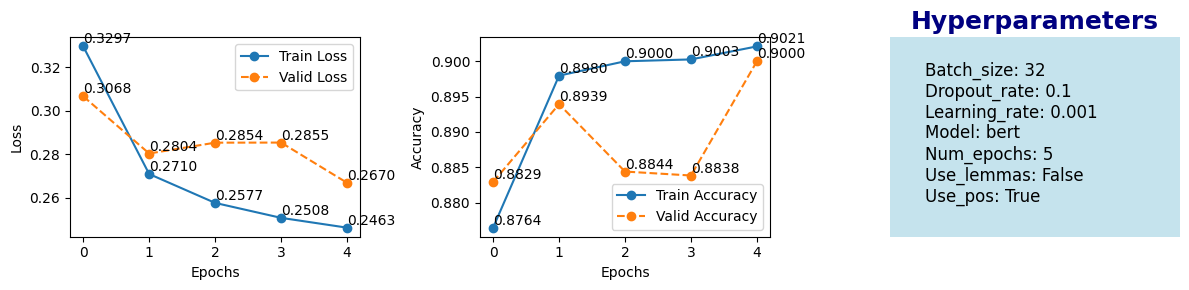

In [91]:
# Replace with the desired experiment path
experiment_path = '/content/drive/MyDrive/nlp2023-hw2/model/logs/wsd_word_pos_bert_2023-09-05_16-12-43/version_0'

# Load the CSV file
csv_file_path = experiment_path+'/metrics.csv'
df = pd.read_csv(csv_file_path)

# Load the hparams.yaml file
hparams_file_path = experiment_path+'/hparams.yaml'
with open(hparams_file_path, 'r') as hparams_file:
    exp_hparams = yaml.safe_load(hparams_file)

# Extract the relevant columns
train_loss = df['train_loss_epoch'].dropna().tolist()
valid_loss = df['valid_loss'].dropna().tolist()
train_accuracy = df['train_accuracy_epoch'].dropna().tolist()
valid_accuracy = df['valid_accuracy'].dropna().tolist()

# Create a list to keep track of epoch boundaries
epochs = range(0, exp_hparams["num_epochs"])

# Create subplots for loss, accuracy, and hyperparameters
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

# Plot train_loss_epoch and valid_loss together
axs[0].plot(epochs, train_loss, label='Train Loss', marker='o')
axs[0].plot(epochs, valid_loss, label='Valid Loss', marker='o', linestyle='--')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Annotate the points with loss values
for x, y in zip(epochs, train_loss):
    axs[0].text(x, y, f'{y:.4f}', ha='left', va='bottom')

for x, y in zip(epochs, valid_loss):
    axs[0].text(x, y, f'{y:.4f}', ha='left', va='bottom')


# Plot train_accuracy_epoch and valid_accuracy together
axs[1].plot(epochs, train_accuracy, label='Train Accuracy', marker='o')
axs[1].plot(epochs, valid_accuracy, label='Valid Accuracy', marker='o', linestyle='--')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Annotate the points with accuracy values
for x, y in zip(epochs, train_accuracy):
    axs[1].text(x, y, f'{y:.4f}', ha='left', va='bottom')

for x, y in zip(epochs, valid_accuracy):
    axs[1].text(x, y, f'{y:.4f}', ha='left', va='bottom')

# Extract all hyperparameters and their values
all_hyperparameters = exp_hparams.items()

# Create a vertical list of hyperparameters with formatting
hyperparameter_list = "\n".join([f"{key.capitalize()}: {value}" for key, value in all_hyperparameters])

# Create a fancy box with rounded corners and shadow for the text
bbox_params = dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightblue', alpha=0.7)
text_box = FancyBboxPatch((0.1, 0.1), 0.8, 0.8, boxstyle="round, pad=0.5", edgecolor='black', facecolor='lightblue', alpha=0.7, transform=axs[2].transAxes, zorder=0)

# Add the fancy box to the plot
axs[2].add_patch(text_box)

# Add the formatted hyperparameters text to the text box
axs[2].text(0.12, 0.88, hyperparameter_list, fontsize=12, verticalalignment='top')

# Remove the axes for a cleaner look
axs[2].axis('off')

# Set a title for hyperparameters with custom font and color
axs[2].set_title('Hyperparameters', fontsize=18, fontweight='bold', color='navy')

# Customize the layout
plt.tight_layout()

# Show the plots
plt.show()


# **Testing phase**

In [92]:
# Replace with the desired experiment path
experiment = 'wsd_word_pos_bert_2023-09-05_16-12-43'
experiment_path = '/content/drive/MyDrive/nlp2023-hw2/model/logs/'+experiment+'/version_0'

# Load the hparams.yaml file
hparams_file_path = experiment_path+'/hparams.yaml'
with open(hparams_file_path, 'r') as hparams_file:
    exp_hparams = yaml.safe_load(hparams_file)
    print(exp_hparams)

{'batch_size': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'model': 'bert', 'num_epochs': 5, 'use_lemmas': False, 'use_pos': True}


In [93]:
exp_model_name = exp_hparams['model']

if exp_model_name == 'roberta':
  exp_model = BertModel.from_pretrained(dir_roberta_model)
  exp_tokenizer = BertTokenizerFast.from_pretrained(dir_roberta_tokenizer)
else:
  exp_model = BertModel.from_pretrained(dir_bert_model)
  exp_tokenizer = BertTokenizerFast.from_pretrained(dir_bert_tokenizer)

test_model = WSDModel.load_from_checkpoint('/content/drive/MyDrive/nlp2023-hw2/model/experiments/wsd_word_pos_bert_2023-09-05_16-12-43/valid_accuracy=0.9000-epoch=4.ckpt', model=exp_model, tokenizer=exp_tokenizer)


In [94]:

test_wsd_dm = WSDDataModule(
    data_train_path=train_json,
    data_dev_path=val_json,
    data_test_path=test_json,
    batch_size= exp_hparams["batch_size"],
    use_lemmas=exp_hparams["use_lemmas"],
)

test_trainer = pl.Trainer(
    max_epochs=1,  # maximum number of epochs.
    gpus=1,  # the number of gpus we have at our disposal.
)

test_trainer.test(model=test_model, datamodule=test_wsd_dm)

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8956407308578491}
--------------------------------------------------------------------------------


[{'test_accuracy': 0.8956407308578491}]